# **Hierarchical - Agglomerative Clustering with Linkage Ward**

In [20]:
import pandas as pd
from scipy.cluster.hierarchy import fcluster, linkage
import numpy as np
import ace_tools_open as tools
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [21]:
df = pd.read_csv('./products_to_package.csv')
df

,set,strike,notional
0,0,1.0035,1660000.0
1,0,1.0037,3480000.0
2,0,1.0054,450000.0
3,0,1.0077,460000.0
4,0,1.0095,1470000.0
...,...,...,...
396,9,1.0941,680000.0
397,9,1.0959,2470000.0
398,9,1.0963,470000.0
399,9,1.0969,390000.0


In [22]:
def fixed_cost(notional):
    return 0.0006 * notional if notional <= 1000000 else 0.0003 * notional

def curve_cost(notional):
    return notional * (11 - 0.5 * np.log(notional)) / 10000

In [24]:
def calculate_individual_cost(final_df):
    set_data = final_df.copy()
    set_data["fixed_cost"] = set_data["notional"].apply(fixed_cost)
    set_data["curve_cost"] = set_data["notional"].apply(curve_cost)
    set_data = set_data.groupby("set")[["fixed_cost", "curve_cost"]].sum().reset_index()
    return set_data

In [25]:
def compute_mad(final_df):
    mad_per_cluster = final_df.groupby(["set", "cluster"]).apply(
        lambda x: np.mean(np.abs(x["strike"] - x["grouped_strike"]))
    ).reset_index(name="MAD")
    mad_per_set = mad_per_cluster.groupby("set")["MAD"].mean().reset_index()
    tools.display_dataframe_to_user(name="Mean Absolute Deviation (MAD) per Cluster", dataframe=mad_per_cluster)
    tools.display_dataframe_to_user(name="Mean Absolute Deviation (MAD) per Set", dataframe=mad_per_set)

In [26]:
def plot_cost(final_df):
    set_data = calculate_individual_cost(final_df)
    final_df["set_cluster"] = final_df["set"].astype(str) + "-" + final_df["cluster"].astype(str)
    cluster_costs_per_set = final_df.copy()
    cluster_costs_per_set = cluster_costs_per_set.drop_duplicates(subset=["set_cluster"])
    cluster_costs_per_set = cluster_costs_per_set.groupby("set")[["fixed_cost", "curve_cost"]].sum().reset_index()

    # Plot 1: Cluster Transaction Costs
    plt.figure(figsize=(14, 6))
    plt.plot(final_df["set_cluster"], final_df["fixed_cost"], label="Fixed Cost", marker="o")
    plt.plot(final_df["set_cluster"], final_df["curve_cost"], label="Curve Cost", marker="s")
    plt.xticks(rotation=90, fontsize=8)
    plt.xlabel("(Set, Cluster) Pair")
    plt.ylabel("Transaction Cost")
    plt.title("Comparison of Transaction Cost Functions Across Clusters (Grouped by Set)")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 2: Comparison Against Individual Costs
    plt.figure(figsize=(12, 6))
    plt.bar(cluster_costs_per_set["set"], cluster_costs_per_set["fixed_cost"], alpha=0.6, label="Sum of Fixed Costs (Clusters)", color="blue")
    plt.bar(cluster_costs_per_set["set"], cluster_costs_per_set["curve_cost"], alpha=0.6, label="Sum of Curve Costs (Clusters)", color="orange")

    for set_id, row in set_data.iterrows():
        plt.hlines(y=row["fixed_cost"], xmin=set_id - 0.4, xmax=set_id + 0.4, linestyle="--", color="blue", alpha=0.8, label="Sum of Individual Fixed Cost" if set_id == 0 else "")
        plt.hlines(y=row["curve_cost"], xmin=set_id - 0.4, xmax=set_id + 0.4, linestyle="--", color="red", alpha=0.8, label="Sum of Individual Curve Cost" if set_id == 0 else "")

    plt.xticks(cluster_costs_per_set["set"])
    plt.xlabel("Set")
    plt.ylabel("Total Transaction Cost")
    plt.title("Comparison of Cluster-Based vs. Individual Set Transaction Costs")
    plt.legend()
    plt.grid()
    plt.show()

In [27]:
def group_products(max_distance):
    grouped_data = []
    for _, group in df.groupby("set"):
        strikes = group["strike"].values.reshape(-1, 1)
        linkage_matrix = linkage(strikes, method="ward")

        if max_distance is not None:
            clusters = fcluster(linkage_matrix, max_distance, criterion="distance")
        else:
            clusters = fcluster(linkage_matrix, t=len(strikes), criterion="maxclust")
            strike_distances = np.diff(np.sort(strikes.flatten()))
            # outliers
            threshold = np.percentile(strike_distances, 95)
            for i in range(1, len(strikes)):
                if strike_distances[i - 1] < threshold:
                    clusters[i] = clusters[i - 1]
        group["cluster"] = clusters
        cluster_mapping = group.groupby("cluster").apply(
            lambda x: pd.Series({
                "grouped_strike": np.average(x["strike"], weights=x["notional"]),
                "cluster_notional": x["notional"].sum()
            })
        ).reset_index()
        group = group.merge(cluster_mapping, on="cluster", how="left")
        grouped_data.append(group)

    final_df = pd.concat(grouped_data)
    final_df = final_df.sort_values(by=["set", "cluster"]).reset_index(drop=True)
    final_df["fixed_cost"] = final_df["cluster_notional"].apply(fixed_cost)
    final_df["curve_cost"] = final_df["cluster_notional"].apply(curve_cost)
    tools.display_dataframe_to_user(name=f'Hierarchical Clustering Result max_dist={max_distance}', dataframe=final_df)
    inertia_per_set = {}
    silhouette_per_set = {}

    for set_id, group in final_df.groupby("set"):
        strikes = group["strike"].values.reshape(-1, 1)
        labels = group["cluster"]

        # Compute Inertia
        cluster_centers = group.groupby("cluster")["strike"].mean()
        inertia = sum((strikes.flatten() - cluster_centers[labels].values) ** 2)
        inertia_per_set[set_id] = inertia

        # Compute Silhouette Score
        if len(set(labels)) > 1:
            silhouette_per_set[set_id] = silhouette_score(strikes, labels)
        else:
            silhouette_per_set[set_id] = np.nan

    print('Inertia:', sum(inertia_per_set.values()))
    print('Silhouette Score:', np.nanmean(list(silhouette_per_set.values())))
    
    plot_cost(final_df)
    compute_mad(final_df)

Hierarchical Clustering Result max_dist=0.02


Inertia: 0.005593591940476201
Silhouette Score: 0.6136432568041769


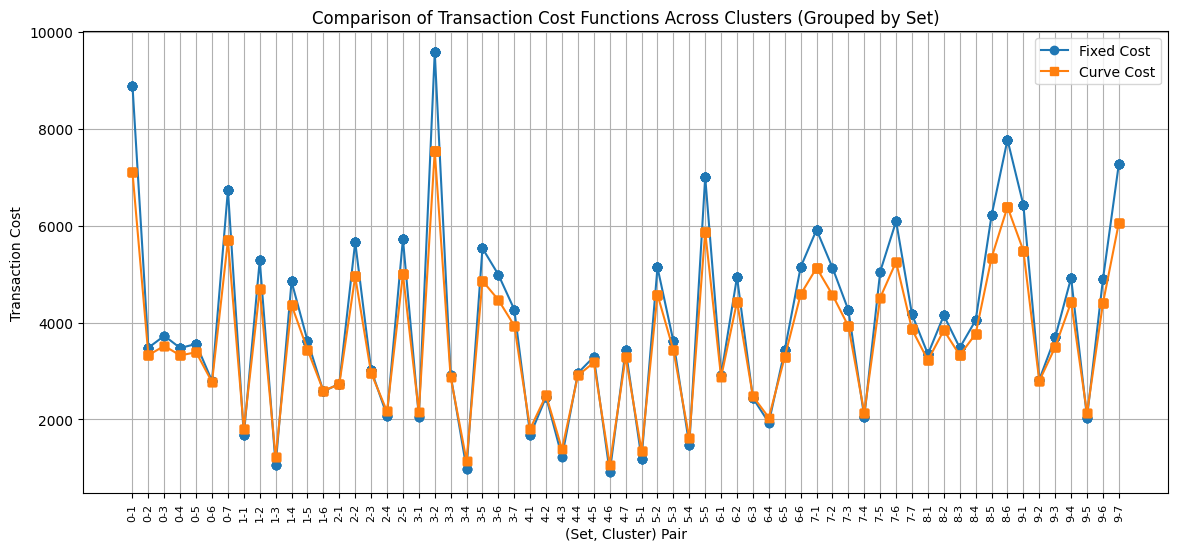

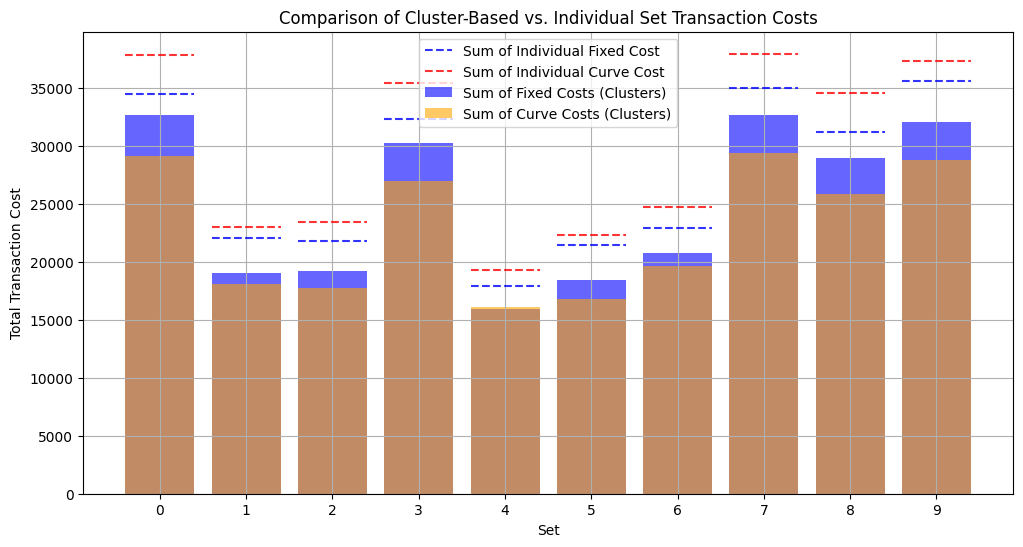

Mean Absolute Deviation (MAD) per Cluster


Mean Absolute Deviation (MAD) per Set


Hierarchical Clustering Result max_dist=0.03


Inertia: 0.009864765710400729
Silhouette Score: 0.6305553305176878


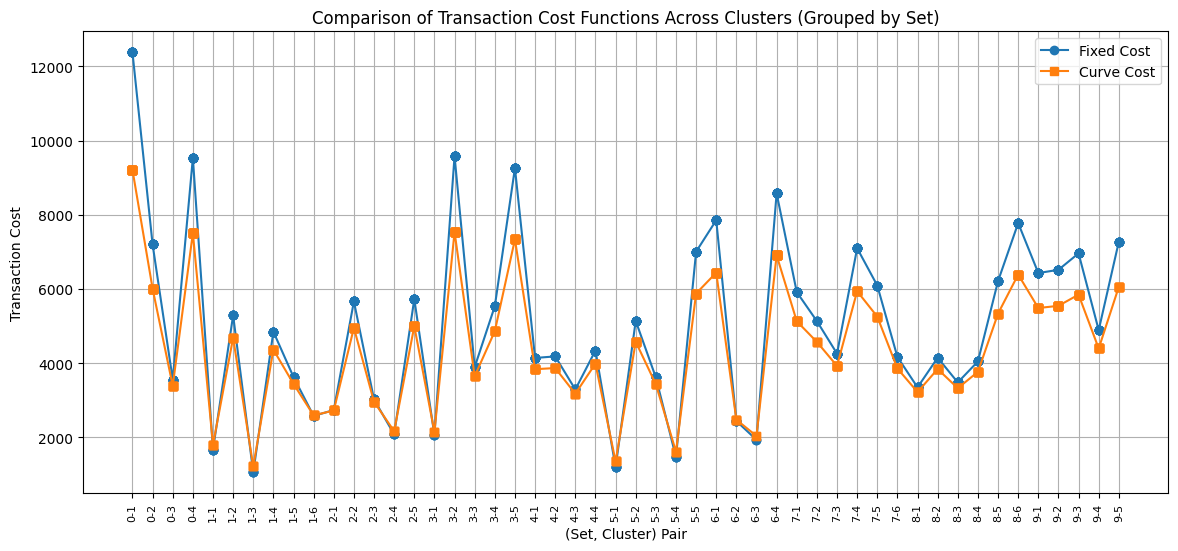

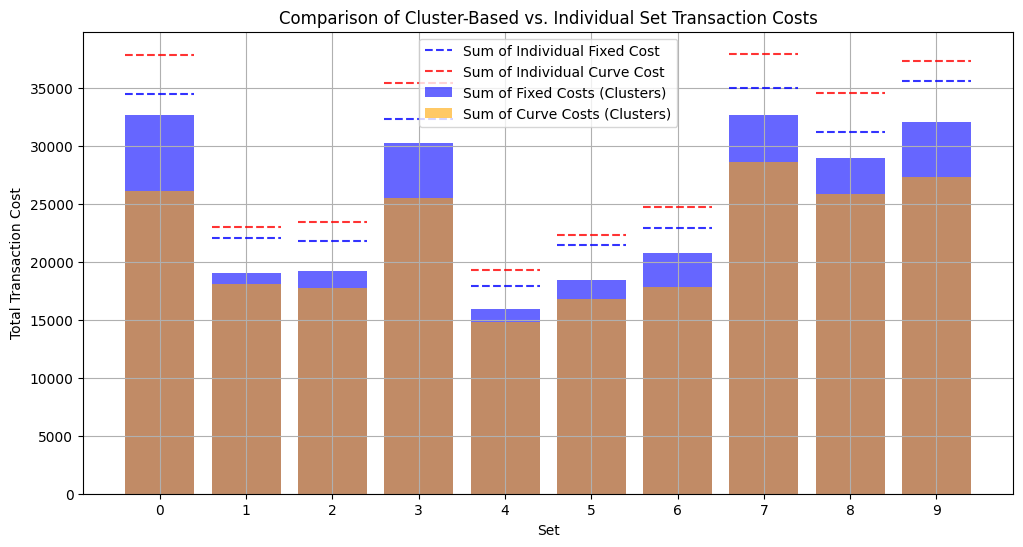

Mean Absolute Deviation (MAD) per Cluster


Mean Absolute Deviation (MAD) per Set


Hierarchical Clustering Result max_dist=0.04


Inertia: 0.01383264385337459
Silhouette Score: 0.6263007003652832


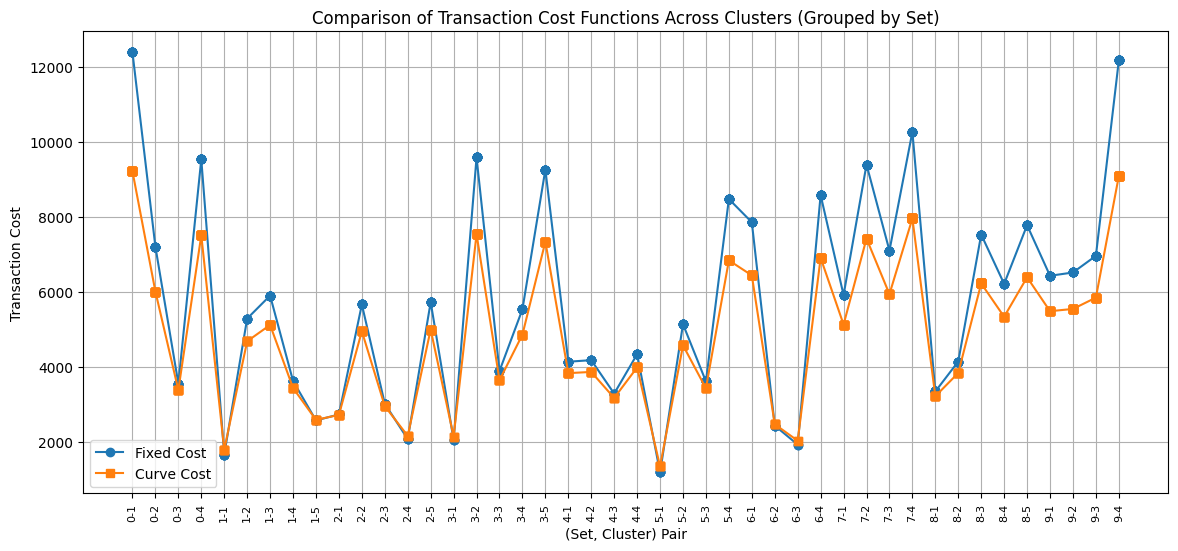

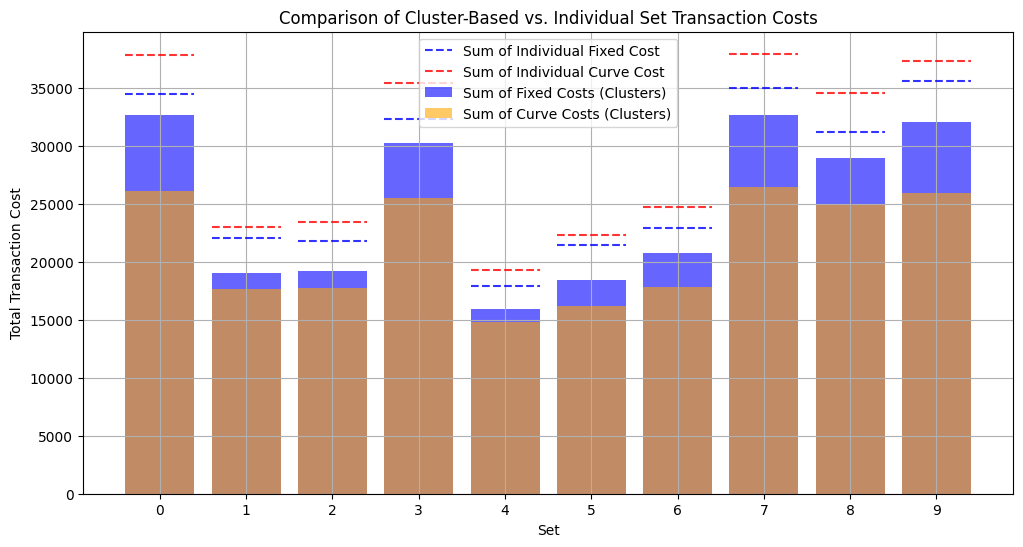

Mean Absolute Deviation (MAD) per Cluster


Mean Absolute Deviation (MAD) per Set


Hierarchical Clustering Result max_dist=None


Inertia: 0.04322499848746204
Silhouette Score: 0.5052547302159917


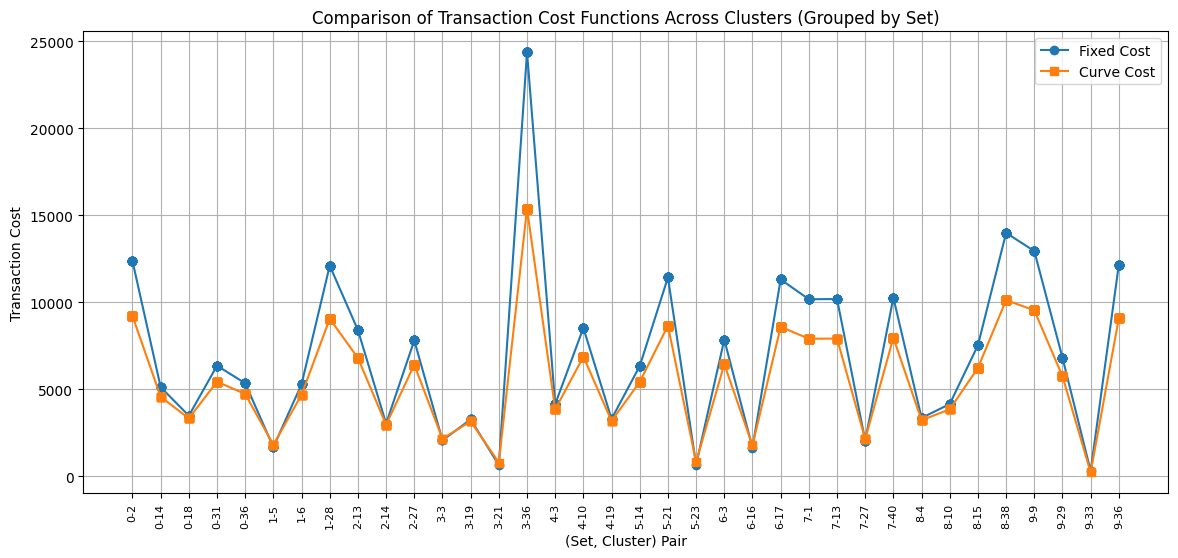

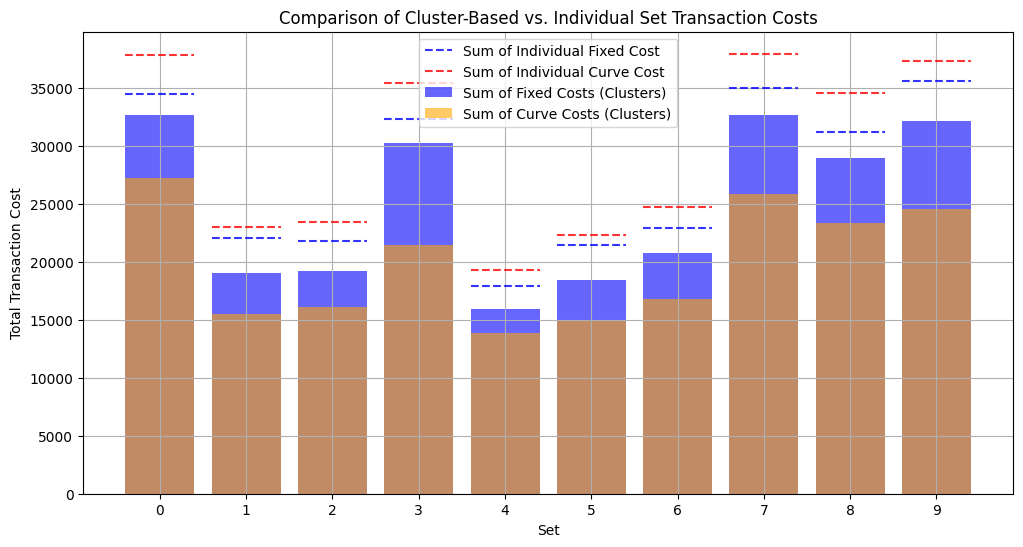

Mean Absolute Deviation (MAD) per Cluster


Mean Absolute Deviation (MAD) per Set


In [28]:
max_distances = [0.02, 0.03, 0.04, None]
for max_distance in max_distances:
    group_products(max_distance)